<a href="https://colab.research.google.com/github/DarshanPatel0919/Deep-Learning/blob/master/LabAssignment8_201701436.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Modules**

In [76]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers, activations, initializers, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Reshape, UpSampling2D, Conv2DTranspose, Activation, Dropout, BatchNormalization
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow_addons.layers import InstanceNormalization as inorm

import sklearn as sk
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold, validation_curve 
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error as mse_fn

import numpy as np
import pandas as pd
from time import time 
from matplotlib import pyplot as plt
from google.colab import drive

from copy import deepcopy

import warnings
warnings.filterwarnings("ignore")

import logging

logger = logging.getLogger()
old_level = logger.level

#**Data Pre-processing**

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train.shape, x_test.shape, y_train[0]

((50000, 32, 32, 3), (10000, 32, 32, 3), array([6], dtype=uint8))

In [4]:
# Normalize input data
x = x_train.astype('float32')/255.0
xt = x_test.astype('float32')/255.0 

In [5]:
## One hot encoding for 10 class classification
y = keras.utils.to_categorical(y_train)
yt = keras.utils.to_categorical(y_test)
y.shape, yt.shape

((50000, 10), (10000, 10))

In [6]:
## One hot encoding for 2 class classification
# cls1, cls2 = 0, 1

# id = np.where((y_train == cls1) | (y_train == cls2))[0]
# xd, yd = x[id], y_train[id]

# id = np.where((y_test == cls1) | (y_test == cls2))[0]
# xdt, ydt = xt[id], y_test[id]

cls=0
yd = np.zeros(y_train.shape)
yd[np.where(y_train == cls )] = 1

ydt = np.zeros(y_test.shape)
ydt[np.where(y_test == cls )] = 1

yd = keras.utils.to_categorical(yd)
ydt = keras.utils.to_categorical(ydt)

yd.shape, ydt.shape

((50000, 2), (10000, 2))

# Helper Functions

In [116]:
def myplot(hist, metric= 'accuracy', st= 0, en= -1, shift=0, label= 'Train', c=''):
  if en == -1:
    en = len(hist[metric])
  
  if metric[:3] == 'val' and label == 'Train':
    label = 'Test'
  
  st = int(st)
  en = int(en)

  x = np.linspace(st+1,en,en-st)+shift
  acc = hist[metric][st:en]

  if len(c):
    plt.plot(x,acc,c,label= label)
  else:
    plt.plot(x,acc,label= label)

  plt.xlabel('Epochs')
  plt.ylabel(metric)

def conv(kernel= 3, filter= 32, trainable= True):
  return Conv2D(
          filters= filter, kernel_size= kernel, strides=(1,1), padding='same', data_format=None,
          dilation_rate=(1, 1), groups=1, activation='relu', use_bias=True,
          kernel_initializer='glorot_uniform', bias_initializer='zeros',
          kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=None, activity_regularizer=None,
          kernel_constraint=None, bias_constraint=None, trainable= trainable
          )
  return y

def deconv(kernel= 3, filter= 32, trainable= True):
  return Conv2DTranspose(
          filters = filter, kernel_size= kernel, strides=(1,1), padding='same', output_padding=None,
          data_format=None, dilation_rate=(1, 1), activation='relu', use_bias=True,
          kernel_initializer='glorot_uniform', bias_initializer='zeros',
          kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None,
          kernel_constraint=None, bias_constraint=None, trainable= trainable
        )
  return y

def rms(alpha=0.0001):
  return tf.keras.optimizers.RMSprop(learning_rate=alpha, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False, name='RMSprop')

# Hyper Parameters

In [8]:
dim = (32,32,3) 
kernel = [1,3,5]
loss = 'categorical_crossentropy'
alpha = 0.0001
opt = 'RMSProp'
merit = 'accuracy'
drop = 0.5
epoch = 25
batch = 32

# **Train Function**


In [9]:
def train(model, epoch= epoch, batch= batch, x=x, y=yd, xt=xt, yt=ydt, verb= 0, callb= 0):
    callback = [EarlyStopping(monitor='loss', patience=2)]
    if callb: callback=[]
    return model.fit(x, y, epochs=epoch, batch_size=batch, verbose=verb, validation_data=(xt,yt),callbacks=callback).history

# Model 1


In [49]:
def build1(k, model4=False, model6=False, compiled=True):
  model = Sequential()
  model.add(Input(dim))
  model.add(conv(k,trainable= ~model4 and ~model6 ))
  model.add(MaxPooling2D())
  model.add(Flatten())
  model.add(Dense(512, activation='relu',trainable= ~model6))
  if model6 == True:
    return model
  model.add(Dense(2, activation='softmax',trainable= ~model6))
  if not compiled:
    return model
  model.compile(opt, loss, merit)
  return model

In [19]:
### Training ### 
model1, hist1 = {},{}
for k in kernel:
  model1[k] = build1(k)
  hist1[k] = train(model1[k])

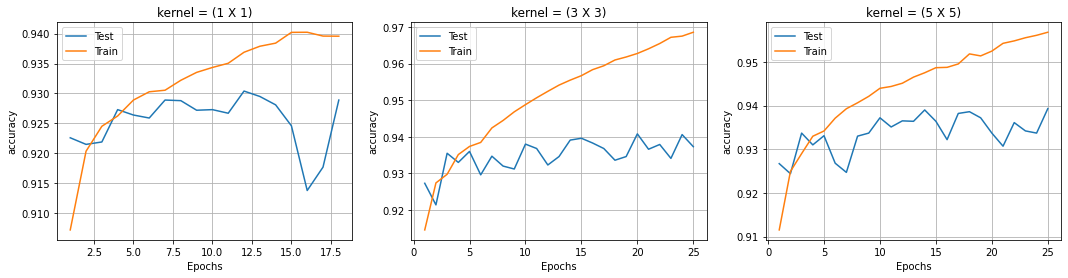

In [172]:
### Validation vs Training accuaracy for Every model ###
plt.figure(figsize=(18,4))
for k in kernel:
  plt.subplot(1,3,k//2 + 1)
  myplot(hist1[k],'val_accuracy')
  myplot(hist1[k])
  plt.legend(loc='best')
  plt.grid()
  plt.title('kernel = ({} X {})'.format(k,k))
plt.show()

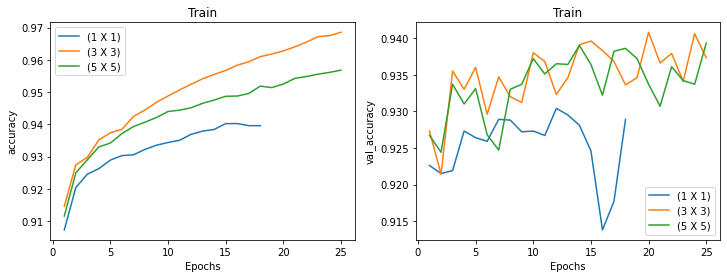

In [173]:
### Comparision ###
plt.figure(figsize=(12,4))
plt.subplot(121)
for k in kernel:
  myplot(hist1[k],label='({} X {})'.format(k,k))
plt.legend(loc='best')
plt.title('Train')

plt.subplot(122)
for k in kernel:
  myplot(hist1[k],'val_accuracy',label='({} X {})'.format(k,k))
plt.legend(loc='lower right')
plt.title('Train')

plt.show()

**Observation** 
* We can Observe that kernel_size = 1 shows very poor results, because without convolution the model is only learning the through the hyper planar attributes of the image
* But when we set to the kernel size to 3, technically we are extracting information regarding all the edges from the image, hence the machine learns well.
* As the size of kernel increases we extract higher order sharp components from the image, but if there are no such components then the learning is not proper since the machine is learning parameters which are not actually useful for classfication task hence kernel_size 5 again gives lesser performance then kernel_size 3.
* Also the testing accuracy is very unstable and lesser because the model is training for only one class and the batch size and number of epochs is too small, for the machine to learn the classification task.  

# Model 2



In [109]:
def build2():
  model = Sequential()
  model.add(Input(dim))
  model.add(conv())
  model.add(conv(5,128))
  model.add(Dropout(drop))  
  model.add(MaxPooling2D())
  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dense(2, activation='softmax'))
  model.compile(opt, loss, merit)
  return model

In [110]:
### Training ### 
model2 = build2()
hist2 = train(model2,callb=1)

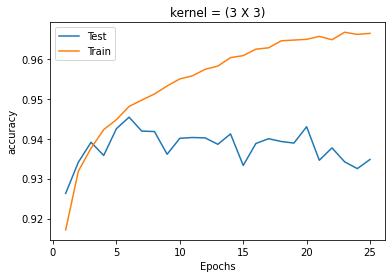

In [111]:
### Validation vs Training accuaracy for Every model ###
myplot(hist2,'val_accuracy')
myplot(hist2)
plt.legend(loc='best')
plt.title('kernel = ({} X {})'.format(3,3))
plt.show()

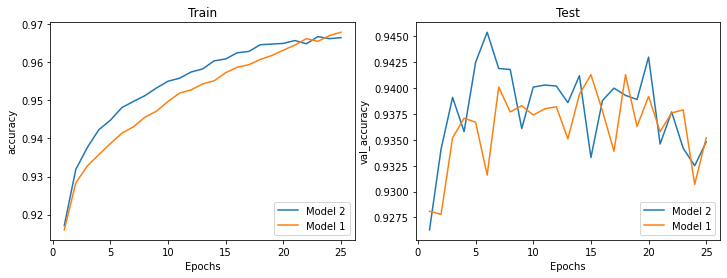

In [112]:
###    Comparision with Model 1     ###
plt.figure(figsize=(12,4))
plt.subplot(121)
myplot(hist2,label='Model 2')
myplot(hist1[3],label='Model 1')
plt.legend(loc='lower right')
plt.title('Train')

plt.subplot(122)
myplot(hist2,'val_accuracy',label='Model 2')
myplot(hist1[3],'val_accuracy',label='Model 1')
plt.legend(loc='lower right')
plt.title('Test')

plt.show()

* By consequtively applying CNN layers we extract much information and machine can learn better.
* MaxPooling is somewhat similar to do faster convolution, where mask is supposed to find maximum element
* But in doing so we might lose some important information, that convolution includes because it calculates over all the values in mask.
* From the result of Model 2 by seeing at the validation errors we can conclude that model 2 is better performing than model 1.

# Model 3



In [40]:
## Undercomplete(Lossy) Autoencoder
def build3(train=True, compiled=True):
  
  model = Sequential()
  model.add(Input(dim))
  model.add(conv(trainable=train))
  model.add(MaxPooling2D())
  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dense(8192, activation='relu'))
  model.add(Reshape((16,16,32)))
  model.add(UpSampling2D())
  model.add(deconv(3,3,trainable=train))
  if not compiled:
    return model
  model.compile(opt, 'mse', 'mse')
  return model

In [11]:
### Train ###
model3 = build3()
hist3 = train(model3,y=x,yt=xt)

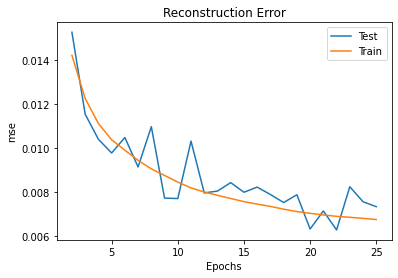

In [12]:
### Validation vs Training accuaracy for Every model ###
myplot(hist3,'val_mse',st=1)
myplot(hist3,'mse',st=1)
plt.legend(loc='best')
plt.title('Reconstruction Error')
plt.show()

* We got very small values of reconstruction error, also the testing MSE is converging as training goes further (increasing size of epochs).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


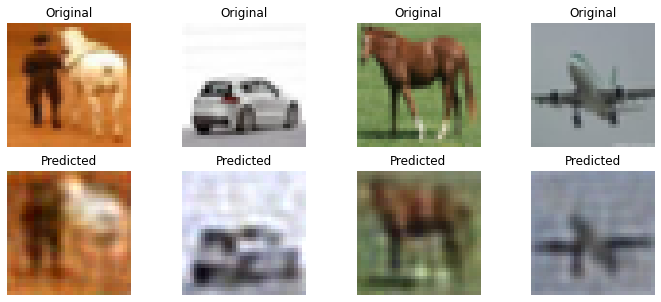

In [15]:
Results = model3.predict(x)

### Sample Images from prediction ###
plt.figure(figsize=(12,5))
for p in range(4):
  i = np.random.randint(len(x))

  actual = x[i]
  plt.subplot(2,4,p+1)
  plt.title('Original')
  plt.imshow(x[i])
  plt.axis('off')

  pred = Results[i]
  pred = np.reshape(pred,dim)
  plt.subplot(2,4,p+5)
  plt.title('Predicted')
  plt.imshow(pred)
  plt.axis('off')

plt.show()
logger.setLevel(old_level)

* Reconstructed imgaes are blurry because the autoencoder is lossy (undercomplete) type.

* Hence even if the mse is very low we can conclude the image reconstruction is very good, we also need to consider the perceptual loss 
* To improve the resolution we need to extract more features from the image which can be done by increasing convolutional layers.

# Model 4


In [20]:
def build4():
  model = build1(k= 3, model4=True, compiled=False)
  model.set_weights(model1[3].get_weights())
  model.compile(opt, loss, merit)
  return model

In [21]:
### Train ###
model4 = build4()
hist4 = train(model4)

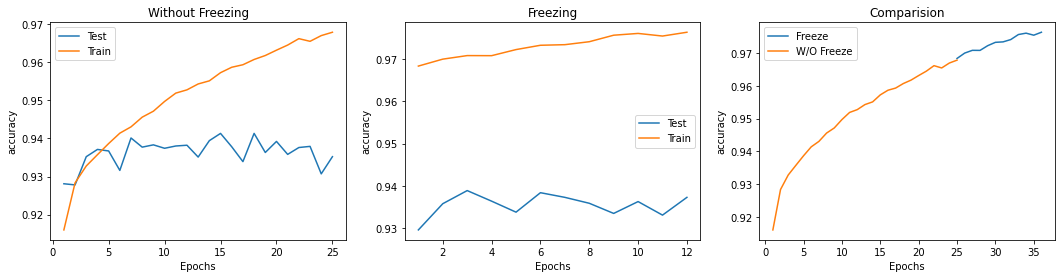

In [22]:
### Validation vs Training accuaracy for Every model ###
plt.figure(figsize=(18,4))

plt.subplot(132)
myplot(hist4,'val_accuracy')
myplot(hist4)
plt.legend(loc='best')
plt.title('Freezing')

plt.subplot(131)
myplot(hist1[3],'val_accuracy')
myplot(hist1[3])
plt.legend(loc='best')
plt.title('Without Freezing')

plt.subplot(133)
myplot(hist4,shift=24,label= 'Freeze')
myplot(hist1[3],label= 'W/O Freeze')
plt.legend(loc='best')
plt.title('Comparision')

plt.show()

* Training of freezed network starts from where it left in the Model 1
* Also, it is very faster because only dense layer is getting trained

# Model 5



In [41]:
def build5():
  model = build3(0,0)
  model.set_weights(model3.get_weights())
  model.add(Flatten())
  model5.add(Dense(512,activation='relu'))
  model.add(Dense(2, activation='softmax'))
  model.compile(opt, loss, merit)
  return model

In [42]:
### Train ###
model5 = build5()
hist5 = train(model5)

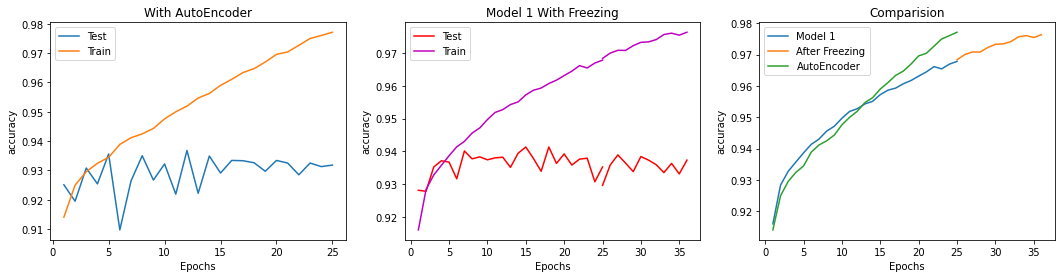

In [43]:
### Validation vs Training accuaracy for Every model ###
plt.figure(figsize=(18,4))

plt.subplot(132)
myplot(hist1[3],'val_accuracy',label='',c='r')
myplot(hist4,'val_accuracy',shift=24,c='r')
myplot(hist1[3],label='',c='m')
myplot(hist4,shift=24,c='m')
plt.legend(loc='best')
plt.title('Model 1 With Freezing')

plt.subplot(131)
myplot(hist5,'val_accuracy')
myplot(hist5)
plt.legend(loc='best')
plt.title('Classification with AutoEncoder')

plt.subplot(133)
myplot(hist1[3],label= 'Model 1')
myplot(hist4,shift=24,label= 'After Freezing')
myplot(hist5,label= 'AutoEncoder')
plt.legend(loc='best')
plt.title('Comparision')

plt.show()

* Autoencoder outperforms the normal cnn classifier because of the learning done by latent layers is boosted by following conv2D transpose layers. The inverse behaviour of transpose layers makes machine learn the features better.

# Model 6


In [52]:
def build6():
  model = build1(3,model6=True,compiled=False)
  model.set_weights(model4.get_weights()[:-2])
  model.add(Dense(10, activation='softmax'))
  model.compile(opt, loss, merit)
  return model

In [129]:
### Train ###
model6 = build6()
hist6 = train(model6,epoch=100, y=y,yt=yt)

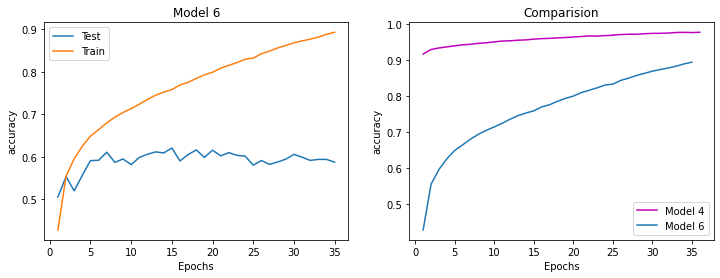

In [60]:
## Comparision with Model 4 
plt.figure(figsize=(12,4))
plt.subplot(122)
myplot(hist1[3],label='',c='m')
myplot(hist4,shift=24,label='Model 4',c='m')
myplot(hist6,label='Model 6')
plt.legend(loc='lower right')
plt.title('Comparision')

plt.subplot(121)
myplot(hist6,'val_accuracy')
myplot(hist6)
plt.legend(loc='best')
plt.title('Model 6')
plt.show()

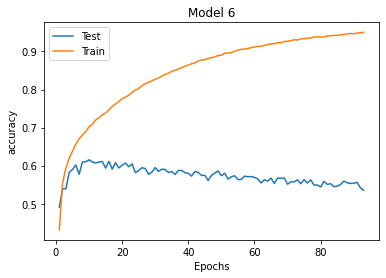

In [130]:
## Performance for 100 epochs
myplot(hist6,'val_accuracy')
myplot(hist6)
plt.legend(loc='best')
plt.title('Model 6')
plt.show()

* The performance of model 6 is lesser than the model 4, since the same pre trained model of 2 class classification is learning for 10 class classification.
* Since the pre trained model here was only used for learning the 2 class classification we conjecture that: the difference in performance is because of the inner dense layers are not getting re trained for in model 6
* In simple words CNN layers strictly target the image features likes edge etc and it does not affect the number of classes that are being used for training.
* Hence a CNN layers always learns about over all image distribution no matter what the architecture is, hence very very useful for image related ML tasks. 

# Final Model


In [125]:
def build():
  model = Sequential()
  model.add(Input(dim))
  model.add(conv(3,32))
  model.add(BatchNormalization())
  model.add(conv(3,32))
  model.add(BatchNormalization())
  model.add(MaxPooling2D())
  model.add(Dropout(0.35))
  model.add(conv(3,64))
  model.add(BatchNormalization())
  model.add(conv(3,64))
  model.add(BatchNormalization())
  model.add(MaxPooling2D())
  model.add(Dropout(0.45))
  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.4))
  model.add(Dense(10, activation='softmax'))
  model.compile('adam', loss, merit)
  return model

In [126]:
### Train ###
model = build()
hist = train(model,epoch=80,batch=500,y=y,yt=yt,verb=0,callb=1)

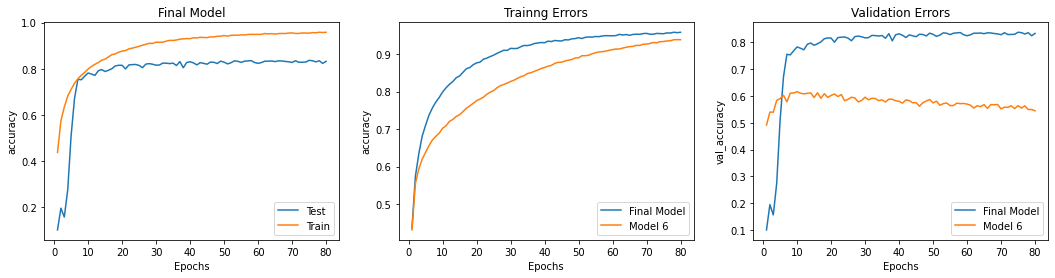

In [137]:
plt.figure(figsize=(18,4))

plt.subplot(133)
myplot(hist,'val_accuracy',label='Final Model')
myplot(hist6,'val_accuracy',en=80,label='Model 6')
plt.legend(loc='lower right')
plt.title('Validation Errors')

plt.subplot(132)
myplot(hist,label='Final Model')
myplot(hist6,en=80,label='Model 6')
plt.legend(loc='lower right')
plt.title('Trainng Errors')

plt.subplot(131)
myplot(hist,'val_accuracy')
myplot(hist)
plt.legend(loc='best')
plt.title('Final Model')
plt.show()

* In final model we are applying every conclusion learned from previous models.
* We observe that training error of model 6 and final model are almost similar
* But there a significant amount of increase in performance on validation set for Final Model.